# Objective

In this tutorial, we will be embarking on a large endeavor to compare theory and experiment in the context of gene expression in *E. coli*. In lecture, we derived a mathematical prediction of how the expression of a reporter gene (YFP) should change in response to increasing copy number of the LacI repressor. Here, we will make plots of our predictions as well as go through all the data analysis needed to plot the data on top of our theory to see how they compare.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Please add this *'data'* folder to your *'Colab Notebooks'* folder if you haven't done it yet.

Whenever we write code, we first need to import all the relevant packages that we will be using, as done below.

In [2]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt

# for image processing
import skimage.measure

# for reading images
import glob

D:\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,



# Part 1: Using phase images to get segmentation masks
##Phase-contrast microscopy (From wikipedia)
Phase-contrast microscopy is an optical microscopy technique that converts phase shifts in light passing through a transparent specimen to brightness changes in the image. Phase shifts themselves are invisible, but become visible when shown as brightness variations.

When light waves travel through a medium other than vacuum, interaction with the medium causes the wave amplitude and phase to change in a manner dependent on properties of the medium. Changes in amplitude (brightness) arise from the scattering and absorption of light, which is often wavelength-dependent and may give rise to colors. Photographic equipment and the human eye are only sensitive to amplitude variations. Without special arrangements, phase changes are therefore invisible. Yet, phase changes often carry important information.

## Objective
We are interested in determining the amount of YFP expression in *E. coli* with varying copy numbers of the repressor, LacI. Before we can assess the amount of fluorescence, we first need to find where the cells are in the image. To do this, it's important to use a channel that is independent of the reporter gene, so we will be using phase images to get our segmentation masks.


## 1.1: Image normalization

Let's first look at one sample image and normalize it. Normalization is necessary since day-to-day variation of illumination may exist for the data and we would like to minimize its effects on the segmentation.

In [3]:
# Open example phase contrast image
im = plt.imread('./data/O1_R1220_phase_pos_00.tif')

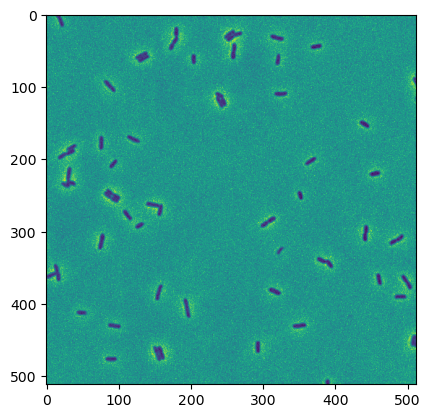

In [4]:
# Show the image
plt.imshow(im)
plt.show()

In [5]:
# Normalize image
im_float = (im - np.min(im))/(np.max(im) - np.min(im))

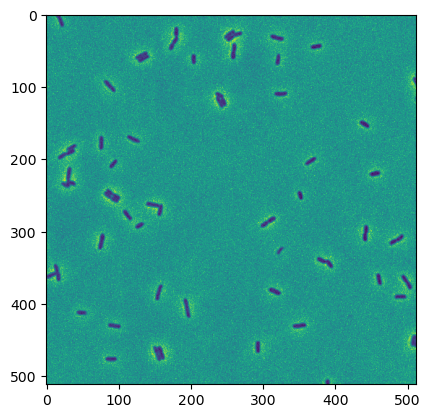

In [6]:
plt.imshow(im_float)
plt.show()

## 1.2: Thresholding

Now that we have cleaned up the image a little bit, we can start to distinguishing bacteria from background. We will do these by *thresholding* the image. Then, we can also plot the histogram of pixel intensities.

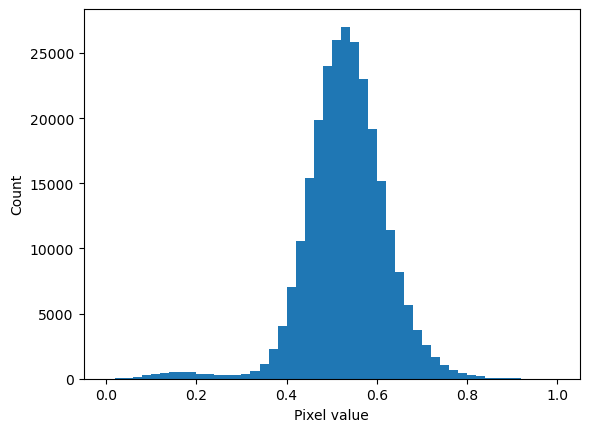

In [7]:
# make histogram of pixel values
plt.hist(im_float.flatten(), bins=50)
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.show()

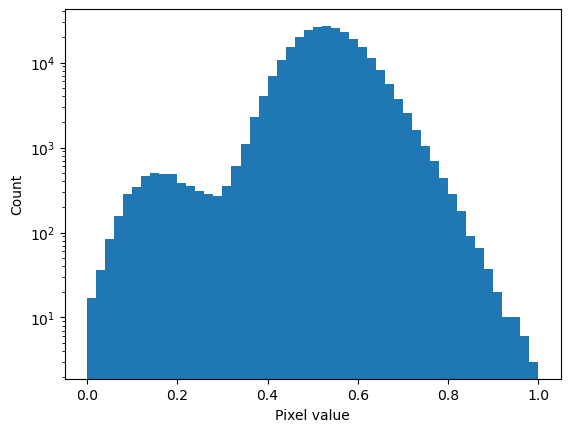

In [8]:
# make histogram of pixel values
plt.hist(im_float.flatten(), bins=50)
plt.yscale('log') # Log scale
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.show()

By plotting with the $y$-axis logarithmically scaled, we can distinguish one hump of low pixel intensities (bacteria) from another hump of high pixel intensities (background). There is a sharp transition around $0.3$ where we transition from bacteria to background, and we will use this as our threshold.

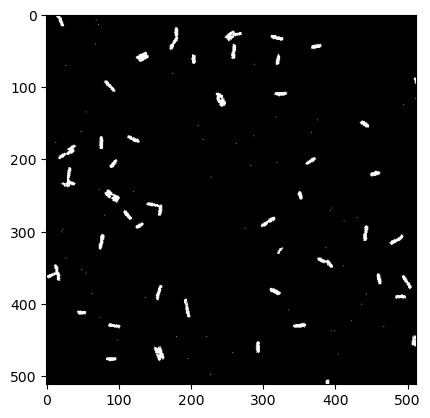

In [9]:
# Choose a threshold manually
threshold = 0.3

# Thresholded image
im_thres = im_float < threshold

# Show thresholded image
plt.imshow(im_thres, cmap='gray')
plt.show()

## 1.3: Label and get sizes of the objects in the image

Our thresholding did okay, but we see we have a lot of single pixels and a lot of clumps that don't correspond to individual bacteria. To remove these features that don't correspond to the bacteria, we will first *label* the image using `skimage.measure.label()`. This function will look for contiguous islands of $1$ pixels in our labeled image and assign each island as an object. Let's label our image and plot the result.

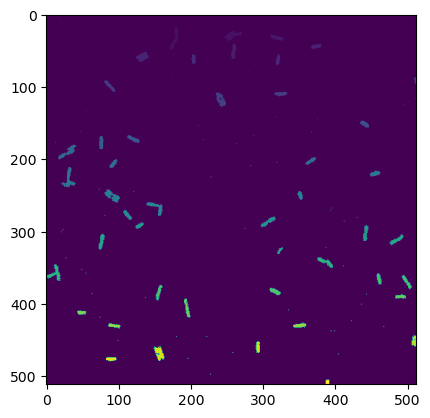

In [10]:
# label the objects in the thresholded image
im_label = skimage.measure.label(im_thres)

# show the labeled image on colorscale
plt.imshow(im_label)
plt.show()

We see that each object whether it's a bacterium, a clump, or a single pixel was assigned a different pixel intensity (i.e. a different color). This is the result of `skimage.measure.label()` assigning all the pixels in the first object with pixel intensity $1$, and all the pixels in the second object with pixel intensity $2$, and so on, until all the objects have been uniquely identified. This means we can find the total number of objects in the image by looking at the maximum value in the image.

In [11]:
print("Objects in image:", np.max(im_label))

Objects in image: 100


Now that we have a labeled image, we will need to perform quality control on our labeled image since some of the segmented regions are much smaller than actual bacteria. We will call `skimage.measure.regionprops()` to compute properties of each unique object. `regionprops` computes many things for us (like centroid, eccentricity, diameter, etc.), but we will just be using area, which accessed by `object.area` for a given object from the labeled image. Let's plot the areas (converted to µm$^2$) of all the objects in our image.

In [12]:
# properties of objects in labelled image
objs = skimage.measure.regionprops(im_label)

# length calibration
pixel_size = 0.16 #um

# list to store area values
n_labels = np.max(im_label)
areas = np.zeros(n_labels)

# loop through the objects and update areas
for i in range(n_labels):
  areas[i] = objs[i].area * (pixel_size**2)

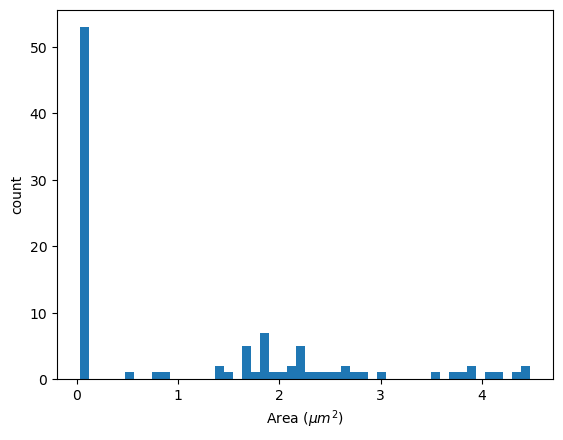

In [13]:
# histogram of the areas
plt.hist(areas, bins=50)
plt.xlabel(r'Area ($\mu m^2$)')
plt.ylabel('count')
plt.show()

## 1.4: Remove non-bacteria objects from the image.

We see that there are a lot of very small objects in the image that certainly aren't bacteria. Additionally, things larger than 4 µm$^2$ are likely multiple bacteria. We would like to remove these objects, and we can do so by initially starting with a blank image (filled with all $0$s), and populating the image with only objects from our labeled image that are of a permissible size.

In [14]:
# area thresholds for what we assign as bacteria
lower_area = 1 # um^2
upper_area = 3 # um^2

# create blank image with same dimensions as target
im_mask = np.zeros_like(im_label)

In [15]:
im_label == objs[6].label

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

C:\Users\hlf20\AppData\Local\Temp\ipykernel_12344\288250606.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


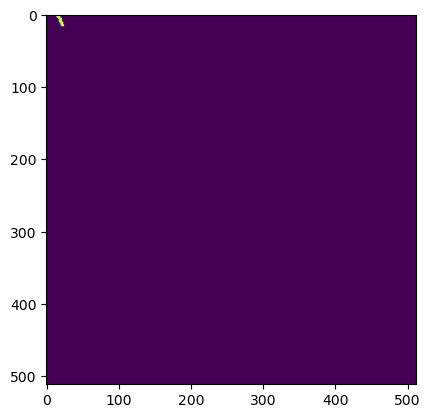

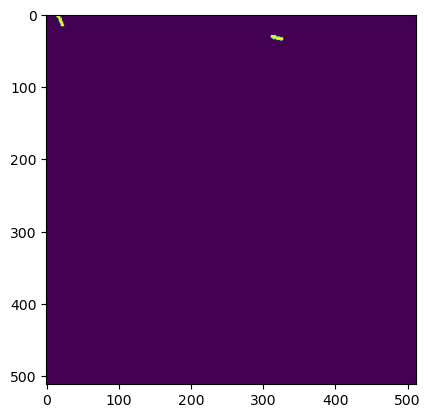

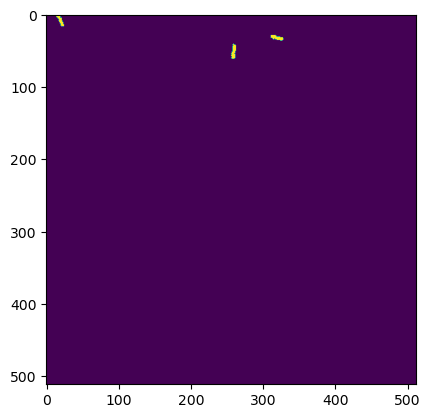

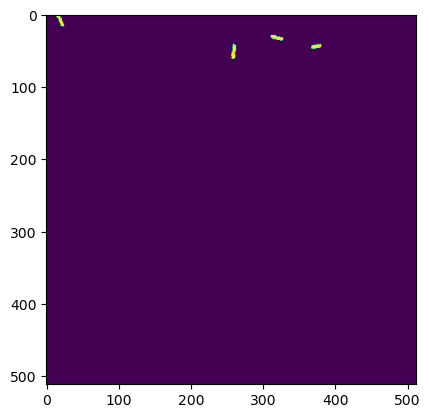

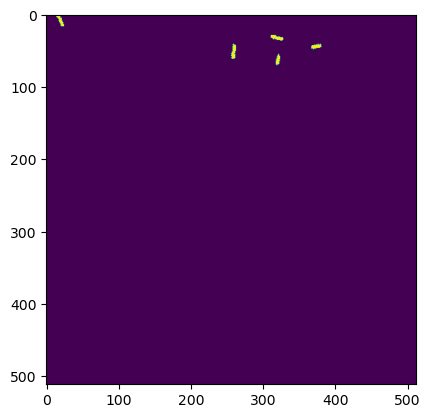

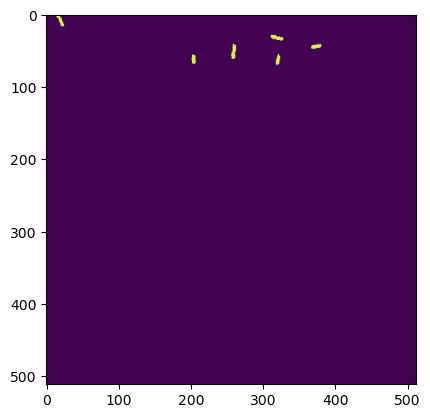

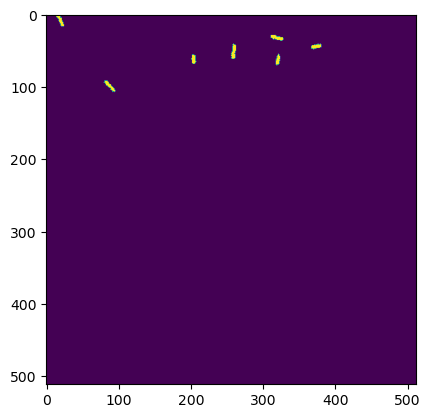

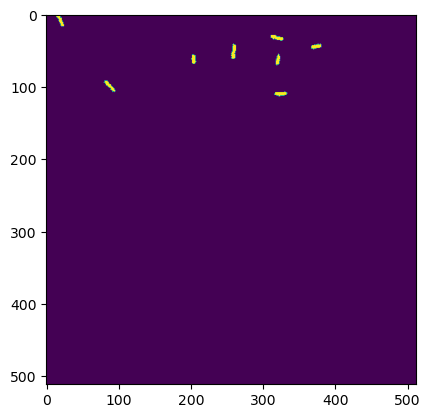

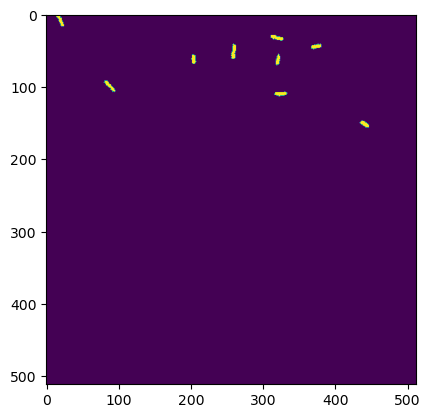

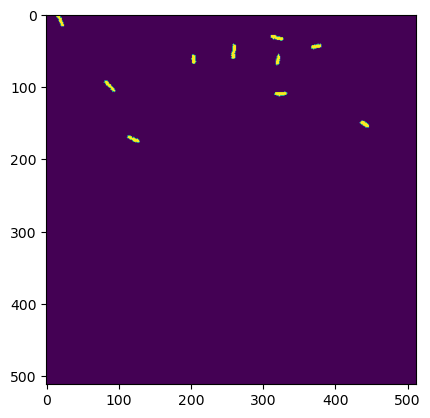

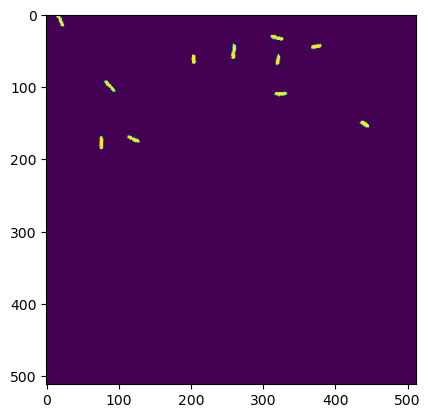

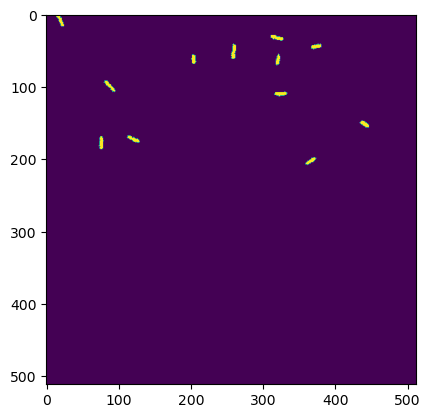

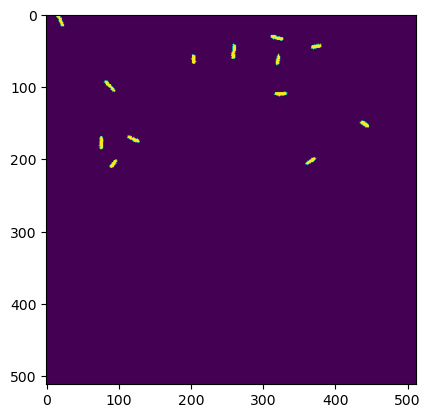

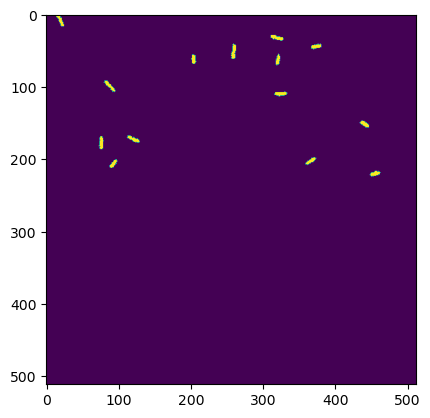

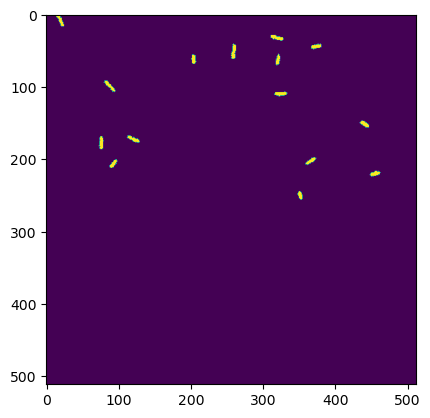

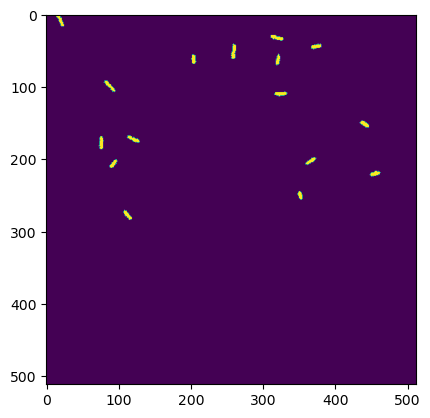

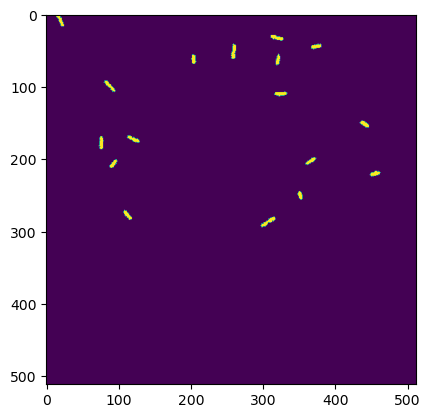

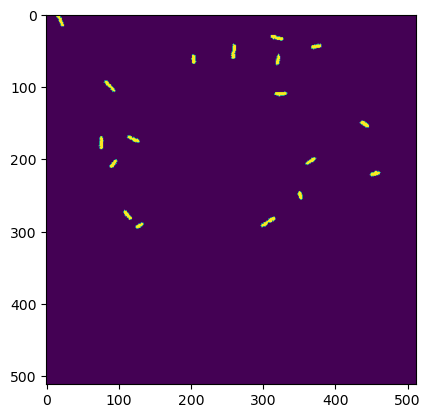

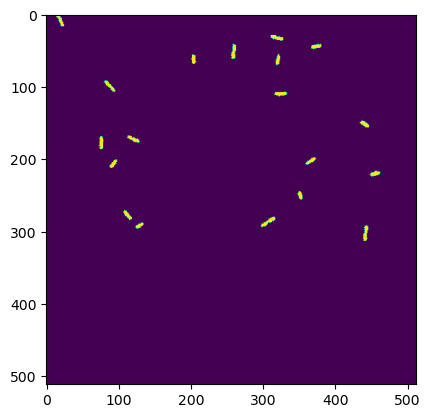

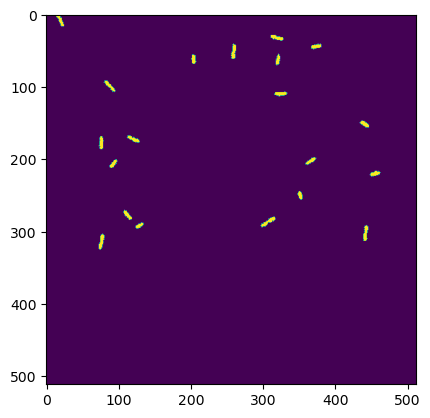

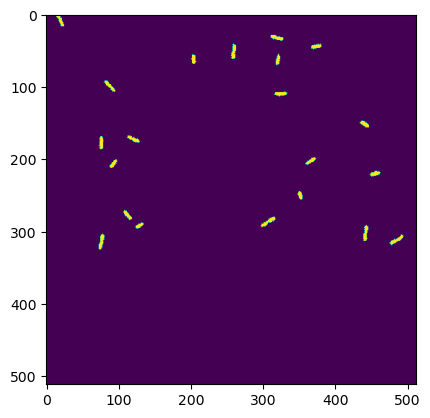

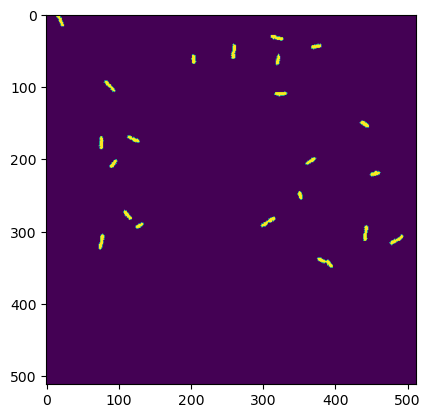

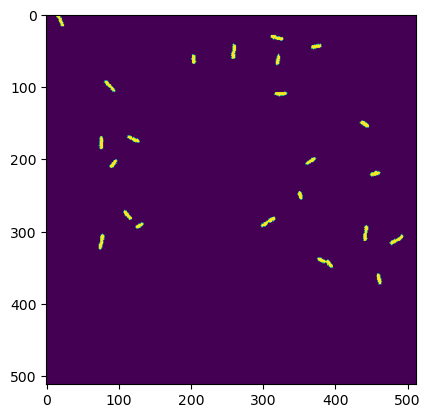

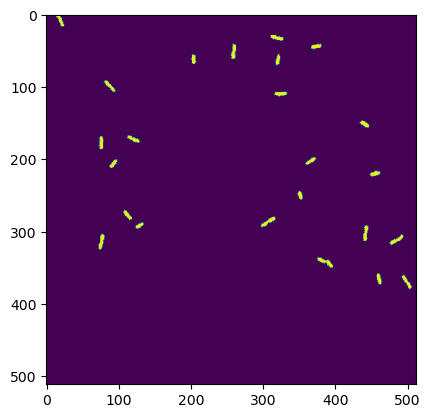

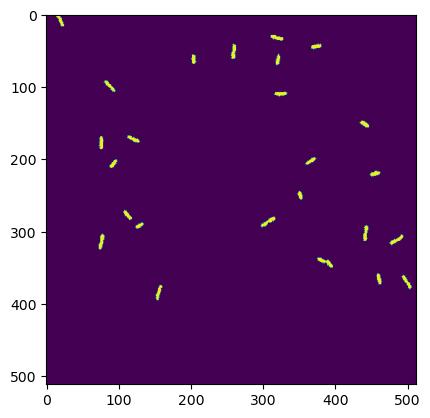

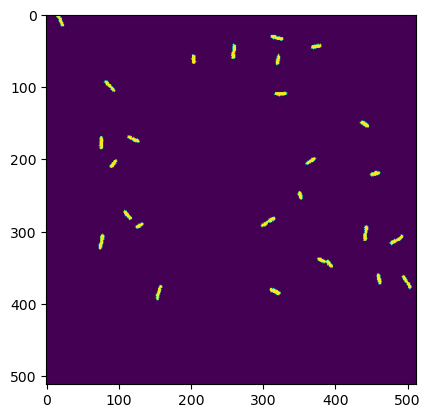

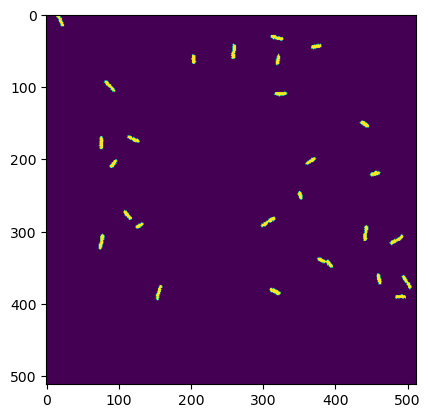

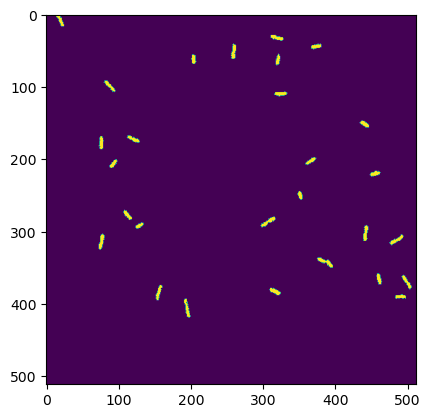

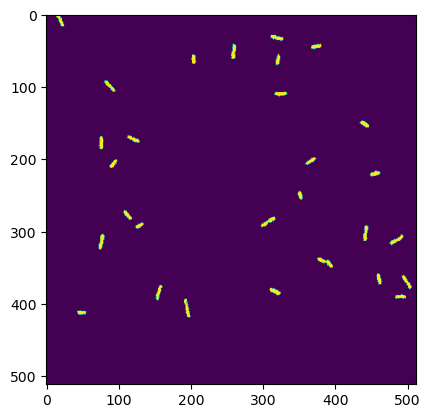

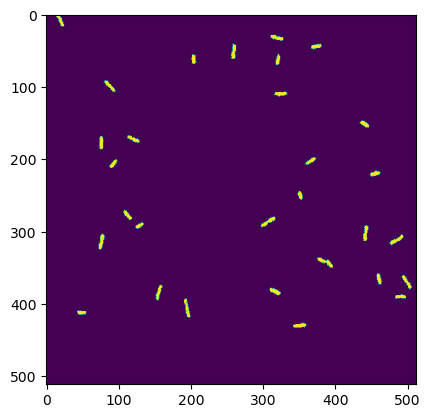

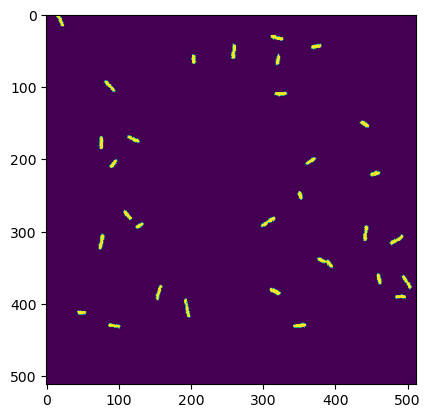

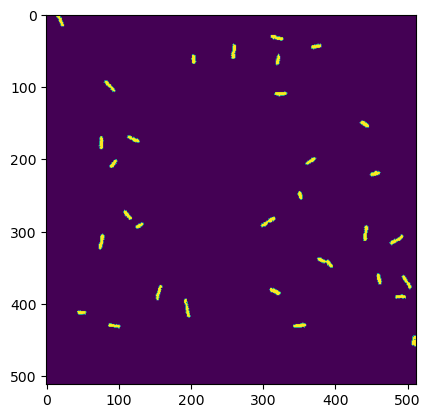

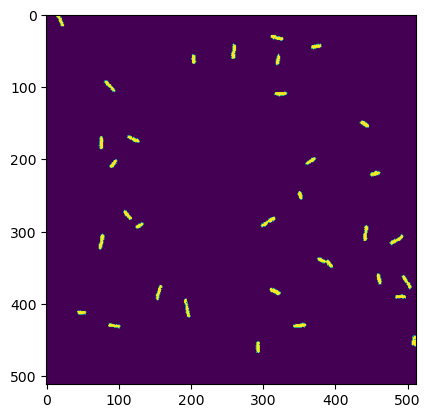

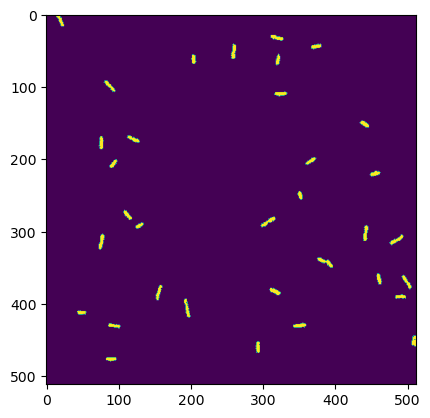

In [16]:
# loop through objects
for i in range(n_labels):
  # Compute area of object
  area = areas[i]

  # if area is within thresholds, add to the mask
  if (area > lower_area) and (area < upper_area):
    im_mask = im_mask + (im_label == objs[i].label)
    # Display the image as each cell is added
    plt.figure()
    plt.imshow(im_mask)

Great! We see that we've cleared out a substantial portion of non-bacteria looking objects. Let's see how many objects remain in this masked image.

In [17]:
# label remaining objects
im_mask_label = skimage.measure.label(im_mask)

# number of objects after filtering
print(im_mask_label.max(), 'objects remain after filtering')

34 objects remain after filtering


# Part 2: Use our segmentation mask to get fluorescence intensities from a YFP image

Now that we have our mask, we are finally ready to assess the level of fluorescence in the corresponding bacteria. Below we show what the corresponding YFP image looks like.

In [18]:
# read matching YFP image
im_yfp = plt.imread('./data/O1_R1220_phase_pos_00.tif')

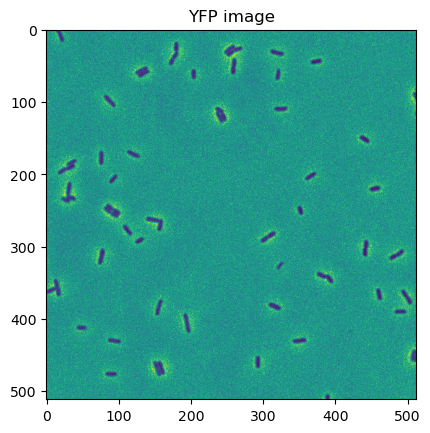

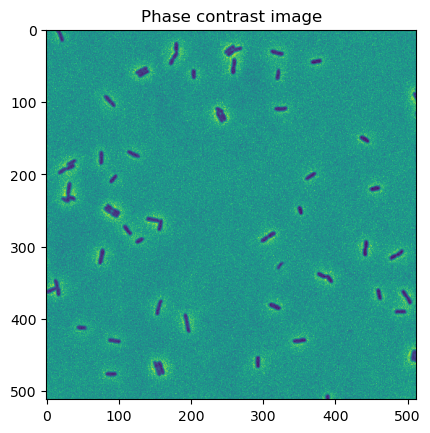

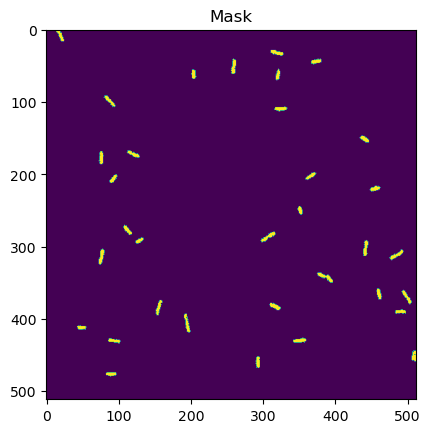

In [19]:
# show images next to each other
plt.imshow(im_yfp)
plt.title('YFP image')
plt.show()

plt.imshow(im)
plt.title('Phase contrast image')
plt.show()

plt.imshow(im_mask)
plt.title('Mask')
plt.show()

With the mask, we can get the fluorescence for each cell. We will first try this with one cell

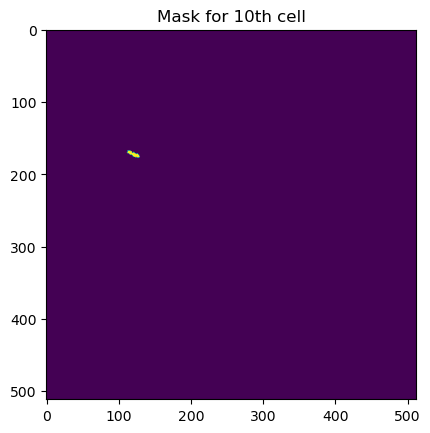

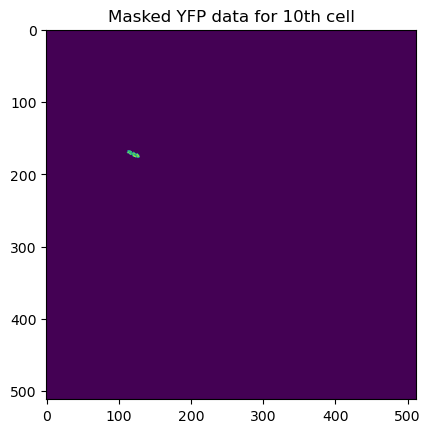

In [20]:
# get a mask for the 10th cell
cell_mask = (im_mask_label == 10)

# use cell mask to get a version of yfp image only for that cell
cell_yfp = im_yfp*cell_mask

# Plot masked data
plt.imshow(cell_mask)
plt.title('Mask for 10th cell')
plt.show()

plt.imshow(cell_yfp)
plt.title('Masked YFP data for 10th cell')
plt.show()

We can get fluorescence for all the cells by looping through the individual cells in the masked image and then referring to the appropriate pixels in the YFP image.

In [21]:
n_cells = np.max(im_mask_label)

# array to store mean yfp intensities
intensities = np.zeros(n_cells)

# loop through cells and find mean intensity for each
for i in range(1, n_cells):
  # get a mask of ith cell
    cell_mask = (im_mask_label == i)

  #use cell mask to get yfp image only for that cell
    cell_yfp = im_yfp * cell_mask

  # use number of pixels in cell to get a mean intensity
    num_pixels = np.sum(cell_mask)
    cell_mean_intensity = np.sum(cell_yfp)/num_pixels

  # update intensity array
    intensities[i] = cell_mean_intensity

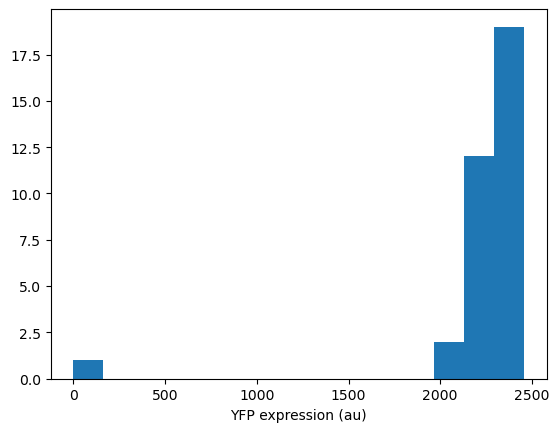

In [22]:
# show intensities
plt.hist(intensities, bins=15)
plt.xlabel("YFP expression (au)")
plt.show()

# Part 3: Get YFP intensities for all images of a given strain

We are making progress towards our ultimate goal of comparing the YFP expression in strains with different binding sites and different repressor copy numbers. We have a pipeline in place that will find the segmentation mask of a phase image and then get the mean intensities of the bacteria in the corresponding YFP image. Let's now work on getting the YFP intensities for **all** the images of a given strain.

In [23]:
# strain information
operator = "O2"
repressor = "R1220"

# filename structure
filename_structure_phase = "./data/" \
                + operator + "_" + repressor + "_phase_pos_*.tif"
filename_structure_yfp = "./data/" \
                + operator + "_" + repressor + "_yfp_pos_*.tif"

# grab all images for this strain
phase_names = glob.glob(filename_structure_phase)
yfp_names = glob.glob(filename_structure_yfp)

# sort images by frame
phase_names.sort()
yfp_names.sort()

In [24]:
# number of frames
n_images = len(phase_names)
intensities_all = np.empty(1) # Creates 1D empty numpy array

# loop through the images
for i in range(n_images):
    im_phase = plt.imread(phase_names[i])
    im_yfp = plt.imread(yfp_names[i])

    # Normalize intensities from YFP image
    im_float = (im_phase - np.min(im_phase))/(np.max(im_phase) - np.min(im_phase))
  
    # Threshold
    threshold = 0.3
    im_thresh = im_float < threshold

    # label objects in binary image
    im_label = skimage.measure.label(im_thresh)

    # Remove nonbacteria or clumps
    pixel_size = 0.16 # um
    lower_area = 1 # um^2
    upper_area = 3 # um^2

    objs = skimage.measure.regionprops(im_label)

    im_mask = np.zeros_like(im_label) # initialize mask

    # loop through objects to clear out garbage
    for obj in objs:
        area = obj.area * pixel_size**2

    # threshold area
        if (area > lower_area) and (area < upper_area):
            im_mask = im_mask + (im_label == obj.label)

    # label remaining objects
    im_mask_label = skimage.measure.label(im_mask)

    # get YFP intensity array
    n_cells = np.max(im_mask_label)
    intensities = np.zeros(n_cells)

    # loop through cells
    for j in range(n_cells):
        cell_mask = (im_mask_label == j) # mask of jth cell
        cell_yfp = im_yfp*cell_mask # yfp image for jth cell
        num_pixels = np.sum(cell_mask)
        cell_mean_intensity = np.sum(cell_yfp)/num_pixels
        intensities[j] = cell_mean_intensity # update intensity
    intensities_all= np.append(intensities_all, intensities) ## Append the cell

    intensities_all[i] = np.nanmean(intensities)

We now have an array of the YFP intensities for all cells in our dataset for our chosen strain. The data we want to plot is the mean intensity for this strain (i.e. for this choice of repressor and operator). You are free to use the full distribution of intensity here to calculate the standard deviations and put error bars on your plot, but we'll ingore that for simplicity's sake.

In [25]:
mean_r = np.mean(intensities_all)

In [26]:
print(mean_r)

200.96623546927052


In [27]:
intensities_all.shape

(1948,)

In [28]:
import numpy as np
import skimage.io
import skimage.measure
import glob
import matplotlib.pyplot as plt

def expression(operator, repressor):
    # Filename structure
    filename_structure_phase = "./data/" + operator + "_" + repressor + "_phase_pos_*.tif"
    filename_structure_yfp = "./data/" + operator + "_" + repressor + "_yfp_pos_*.tif"

    # Grab all images for this strain
    phase_names = glob.glob(filename_structure_phase)
    yfp_names = glob.glob(filename_structure_yfp)

    # Sort images by frame
    phase_names.sort()
    yfp_names.sort()

    # Number of frames
    n_images = len(phase_names)
    intensities_all = np.empty(0)  # Creates 1D empty numpy array

    # Loop through the images
    for i in range(n_images):
        im_phase = plt.imread(phase_names[i])
        im_yfp = plt.imread(yfp_names[i])

        # Normalize intensities from YFP image
        im_float = (im_phase - np.min(im_phase)) / (np.max(im_phase) - np.min(im_phase))

        # Threshold
        threshold = 0.3
        im_thresh = im_float < threshold

        # Label objects in binary image
        im_label = skimage.measure.label(im_thresh)

        # Remove nonbacteria or clumps
        pixel_size = 0.16  # um
        lower_area = 1  # um^2
        upper_area = 3  # um^2

        objs = skimage.measure.regionprops(im_label)
        im_mask = np.zeros_like(im_label)  # Initialize mask

        # Loop through objects to clear out garbage
        for obj in objs:
            area = obj.area * pixel_size**2
            # Threshold area
            if lower_area < area < upper_area:
                im_mask = im_mask + (im_label == obj.label)

        # Label remaining objects
        im_mask_label = skimage.measure.label(im_mask)

        # Get YFP intensity array
        n_cells = np.max(im_mask_label)
        intensities = np.zeros(n_cells)

        # Loop through cells
        for j in range(1, n_cells + 1):  # Corrected the range to start at 1
            cell_mask = (im_mask_label == j)  # Mask of jth cell
            cell_yfp = im_yfp * cell_mask  # YFP image for jth cell
            num_pixels = np.sum(cell_mask)
            cell_mean_intensity = np.sum(cell_yfp) / num_pixels if num_pixels > 0 else np.nan  # Avoid division by zero
            intensities[j - 1] = cell_mean_intensity  # Update intensity

        # Append the cell intensities for this image to the main array
        intensities_all = np.append(intensities_all, intensities[intensities > 0])  # Append non-zero intensities

    mean_R = np.nanmean(intensities_all)
    print("Operator: ", operator, ", Repressor: ", repressor)
    print(mean_R)
    return mean_R


In [29]:
Repressor_names = ["auto", "delta", "R22", "R60", "R124", "R260", "R1220"]
Operator_names = ["O1", "O2", "O3"]
mean_R_nums = np.zeros(21)
i = 0
for operator in Operator_names:
    for repressor in Repressor_names:
        mean_R_nums[i] = expression(operator, repressor)
        i += 1

mean_R_nums

Operator:  O1 , Repressor:  auto
152.7556568967376
Operator:  O1 , Repressor:  delta
2653.1930623502276
Operator:  O1 , Repressor:  R22
246.90136006026984
Operator:  O1 , Repressor:  R60
187.12281698115854
Operator:  O1 , Repressor:  R124
172.48361916914016
Operator:  O1 , Repressor:  R260
165.5409827689931
Operator:  O1 , Repressor:  R1220
166.77602252141898
Operator:  O2 , Repressor:  auto
154.62410914188237
Operator:  O2 , Repressor:  delta
2115.6194050763334
Operator:  O2 , Repressor:  R22
815.1585034386238
Operator:  O2 , Repressor:  R60
264.3113821119059
Operator:  O2 , Repressor:  R124
222.15928308687387
Operator:  O2 , Repressor:  R260
196.97975095819586
Operator:  O2 , Repressor:  R1220
202.9937304228771
Operator:  O3 , Repressor:  auto
151.9664432273414
Operator:  O3 , Repressor:  delta
7063.977907331687
Operator:  O3 , Repressor:  R22
6325.965833925794
Operator:  O3 , Repressor:  R60
6017.252465626061
Operator:  O3 , Repressor:  R124
6420.024564742432
Operator:  O3 , Repress

array([ 152.7556569 , 2653.19306235,  246.90136006,  187.12281698,
        172.48361917,  165.54098277,  166.77602252,  154.62410914,
       2115.61940508,  815.15850344,  264.31138211,  222.15928309,
        196.97975096,  202.99373042,  151.96644323, 7063.97790733,
       6325.96583393, 6017.25246563, 6420.02456474, 4747.3370864 ,
       3197.37406299])

In [31]:
def fold_change(F_total_R, F_total_R0, F_auto):
    """
    Calculate the fold-change in gene expression.

    Parameters:
    - F_total_R: The total fluorescence for a given number of repressors R.
    - F_total_R0: The total fluorescence with no repressors (R=0), i.e., delta condition.
    - F_auto: The autofluorescence of the cell, i.e., auto condition.

    Returns:
    - The fold-change in gene expression.
    """
    fold_change = (F_total_R - F_auto) / (F_total_R0 - F_auto)
    return fold_change


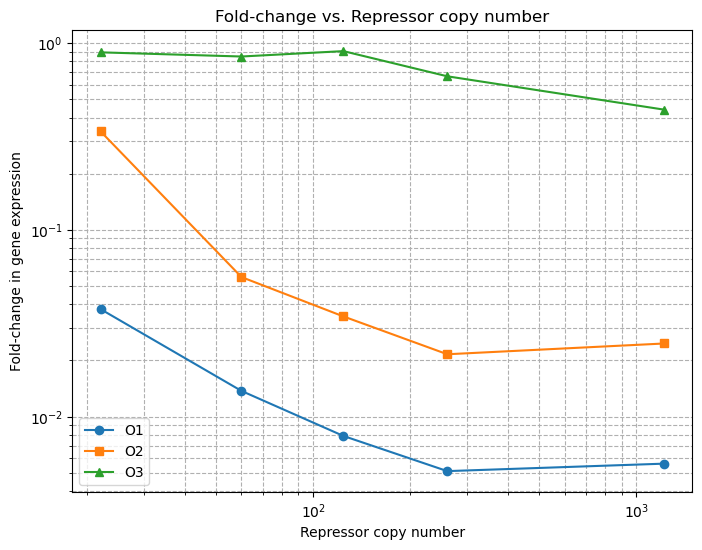

In [34]:
# 为O1、O2和O3计算fold-change
fold_changes_O1 = np.zeros(5)  # 不包括 auto 和 delta 条件
fold_changes_O2 = np.zeros(5)
fold_changes_O3 = np.zeros(5)

for i in range(5):  # R22, R60, R124, R260, R1220
    fold_changes_O1[i] = fold_change(mean_R_nums[i+2], mean_R_nums[1], mean_R_nums[0])
    fold_changes_O2[i] = fold_change(mean_R_nums[i+9], mean_R_nums[8], mean_R_nums[7])
    fold_changes_O3[i] = fold_change(mean_R_nums[i+16], mean_R_nums[15], mean_R_nums[14])

# Repressor 拷贝数对应 R22, R60, R124, R260, R1220
repressor_copy_numbers = np.array([22, 60, 124, 260, 1220])

# 绘制fold-change的对数-对数图
plt.figure(figsize=(8, 6))
plt.loglog(repressor_copy_numbers, fold_changes_O1, 'o-', label='O1')
plt.loglog(repressor_copy_numbers, fold_changes_O2, 's-', label='O2')
plt.loglog(repressor_copy_numbers, fold_changes_O3, '^-', label='O3')

plt.xlabel('Repressor copy number')
plt.ylabel('Fold-change in gene expression')
plt.title('Fold-change vs. Repressor copy number')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


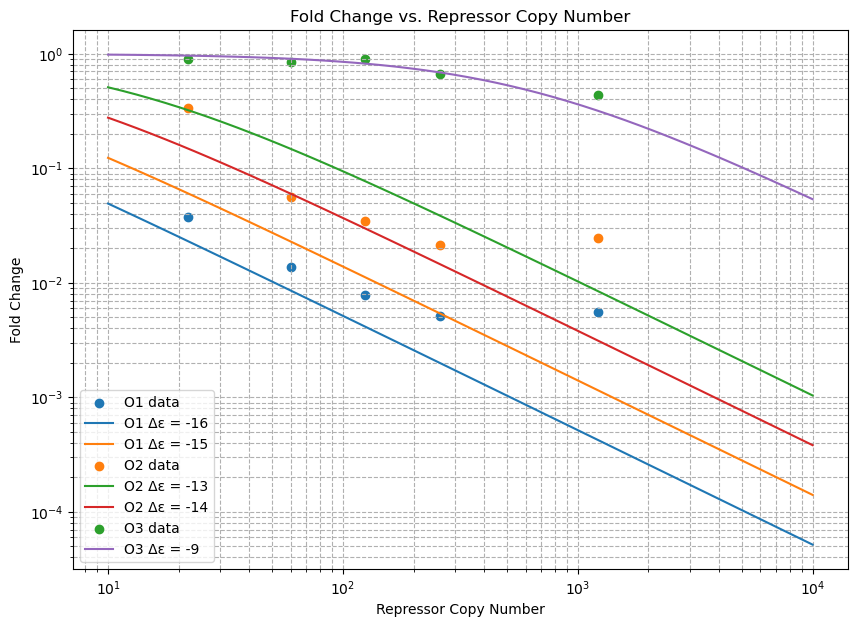

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# 已知的 R 值和相应的 fold-change 结果
R_values = np.array([22, 60, 124, 260, 1220])
fold_changes_O1 = np.array(fold_changes_O1)
fold_changes_O2 = np.array(fold_changes_O2)
fold_changes_O3 = np.array(fold_changes_O3)

# 定义模型
def fold_change_model(R, N_NS, beta, delta_epsilon):
    return 1 / (1 + (R / N_NS) * np.exp(-beta * delta_epsilon))

# 参数
N_NS = 4.6e6  # 非特异性位点的数量
beta = 1  # 简化处理，β=1

# Δε 的尝试值
delta_epsilon_values = {
    'O1': [-16, -15],  # 根据需要调整这些值
    'O2': [-13, -14],
    'O3': [-9]
}

# 绘图
plt.figure(figsize=(10, 7))

operators = ['O1', 'O2', 'O3']
fold_changes = [fold_changes_O1, fold_changes_O2, fold_changes_O3]

for i, operator in enumerate(operators):
    # 绘制实验数据
    plt.scatter(R_values, fold_changes[i], label=f'{operator} data')
    
    # 绘制模型预测
    R_range = np.logspace(1, 4, 50)  # 用于绘图的抑制子拷贝数范围
    for delta_epsilon in delta_epsilon_values[operator]:
        fold_change_pred = fold_change_model(R_range, N_NS, beta, delta_epsilon)
        plt.plot(R_range, fold_change_pred, label=f'{operator} Δε = {delta_epsilon}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Repressor Copy Number')
plt.ylabel('Fold Change')
plt.title('Fold Change vs. Repressor Copy Number')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


Optimized K_d for O1: 0.8666236833729484 (arbitrary units)
Optimized K_d for O2: 8.829230910194614 (arbitrary units)
Optimized K_d for O3: 733.0909877738068 (arbitrary units)


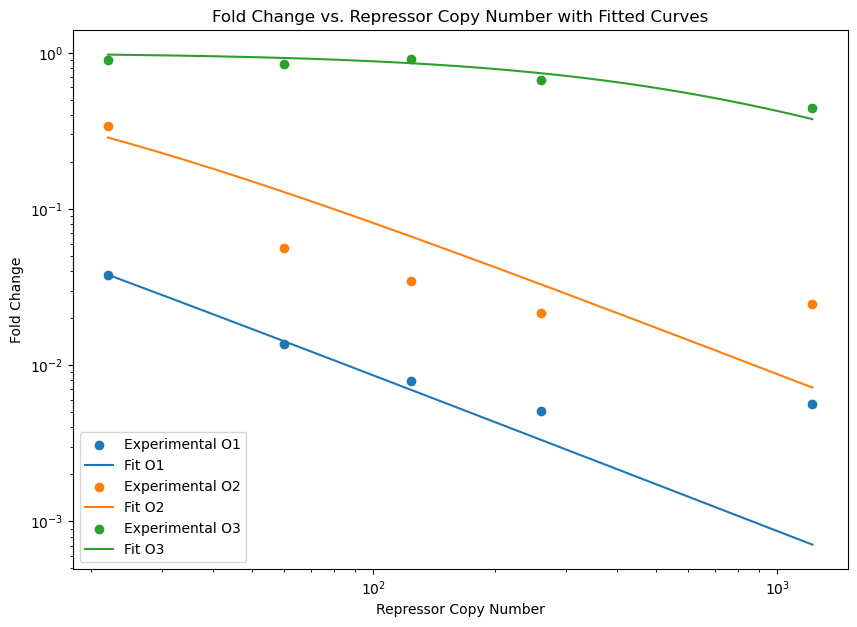

In [39]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# 定义方程(7)的模型函数
def fold_change_model(R, K_d):
    """
    折叠变化模型，基于解离常数 K_d 和抑制子浓度 R。
    """
    return 1 / (1 + R / K_d)

# 已知的 R 值和相应的 fold-change 结果
R_values = np.array([22, 60, 124, 260, 1220])

# 对每个 unique operator 执行最小二乘拟合
operators = ['O1', 'O2', 'O3']
fold_changes = [fold_changes_O1, fold_changes_O2, fold_changes_O3]

K_d_optimized = {}  # 用于存储每个操作符的最优 K_d 值

for operator, fold_change in zip(operators, fold_changes):
    # 使用 curve_fit 函数执行拟合
    popt, _ = curve_fit(fold_change_model, R_values, fold_change, p0=[10])
    
    # 将最优 K_d 值存储在字典中
    K_d_optimized[operator] = popt[0]

# 打印每个操作符的最优 K_d 值
for operator, K_d in K_d_optimized.items():
    print(f'Optimized K_d for {operator}: {K_d} (arbitrary units)')

# 可选：绘制实验数据和拟合曲线进行比较
plt.figure(figsize=(10, 7))

for operator, fold_change in zip(operators, fold_changes):
    plt.scatter(R_values, fold_change, label=f'Experimental {operator}')
    
    # 绘制拟合曲线
    R_range = np.linspace(min(R_values), max(R_values), 500)
    plt.plot(R_range, fold_change_model(R_range, K_d_optimized[operator]), label=f'Fit {operator}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Repressor Copy Number')
plt.ylabel('Fold Change')
plt.title('Fold Change vs. Repressor Copy Number with Fitted Curves')
plt.legend()
plt.show()
